## Exploratory data analysis for Lego database
Brian Silverstein  

### Rebrickable updates this database monthly.  
https://rebrickable.com/downloads/

#### Possible capstone project soure file -- just not sure yet what to do with it.
Galvanize Data Science Immersion course, Seattle  

#### Possibly scrape ebay data on prices by set?
As of July 23, there are 407,929 lego listings on Ebay  
https://www.ebay.com/sch/i.html?_from=R40&_sacat=0&_nkw=lego&_ipg=200&rt=nc  
99,751 results for lego minifigures  
Uncleaned, unsorted lots go for as little as 2 bucks a pound... sorted up to 50, but 12 is more typical including shipping.  

#### Automatic sorter article on Make:
http://makezine.com/2015/07/20/sort-legos-like-engineer/

#### Sorter into 8 groups:
https://www.youtube.com/watch?v=6lZ9rSZwDzE

#### Possibly use as starting point for classifier which can tell what peices are?

### Consider the pipelines:
- Can I do real-time updates?
- What does a miniature version look like:
   - Sort 30 pieces?
   - df-idf on only 100 sets?
   - Webscrape ebay only -- add ToysRUs later, Wal-mart, Target

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Allow inline graphing in Notbook
%matplotlib inline
# Always make it pretty.
plt.style.use('ggplot')

from IPython.display import Image
from collections import Counter
import operator
import os

Organization of data in data files is as shown:


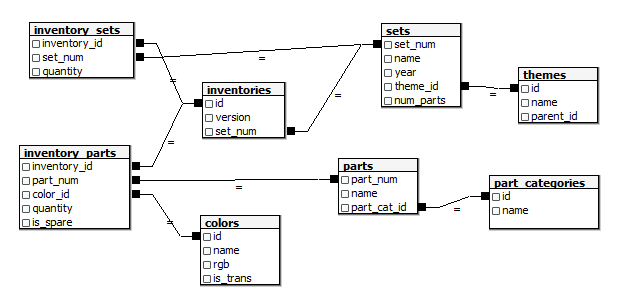

In [3]:
print "Organization of data in data files is as shown:"
Image("../rebrickable data/downloads_schema.png")

In [15]:
curr_dir = '../rebrickable data/2017-09/'

colors = pd.read_csv(curr_dir + 'colors.csv')
inventories = pd.read_csv(curr_dir + 'inventories.csv')
inventory_parts = pd.read_csv(curr_dir + 'inventory_parts.csv')
inventory_sets = pd.read_csv(curr_dir + 'inventory_sets.csv')
part_categories = pd.read_csv(curr_dir + 'part_categories.csv')
parts = pd.read_csv(curr_dir + 'parts.csv')
sets = pd.read_csv(curr_dir + 'sets.csv')
themes = pd.read_csv(curr_dir + 'themes.csv')

In [4]:
def set_id_from_kit_name(lego_set):
    '''
    INPUT:  lego_set (string): set_num in inventory_sets, sets, and inventories
    OUTPUT: inventory_id (int): in inventory_sets, inventory_parts
    '''
    inventory_set = inventories[inventories['set_num']==lego_set]
    inventory_id = np.max(inventory_set['id'])
    return inventory_id

In [5]:
def lists_from_inv_id(lego_set, occ):
    '''
    INPUTS:  lego_set (string): set_num in inventory_sets, sets, and inventories
             occ (dict): all part numbers in bag of words, counted
    OUTPUTS: this_set_occ (dict): part numbers in this lego set, counted
             this_set_term_freq (dict): part numbers in this lego set, frequncy
             this_set_parts (pandas DataFrame): filtered subset of inventory_parts
             inventory_id (int): in inventory_sets, inventory_parts 
    '''
    inventory_id = set_id_from_kit_name(lego_set)

    this_set_parts = inventory_parts[inventory_parts['inventory_id']==inventory_id]

    this_set_occ={}
    this_set_term_freq={}
    this_set_piece_count=1.0*sum(this_set_parts['quantity'])
    
    for part_id,part_count in zip(this_set_parts['part_num'],this_set_parts['quantity']):
        occ[part_id]= occ.get(part_id,0)+part_count
        this_set_occ[part_id]= this_set_occ.get(part_id,0)+part_count
        this_set_term_freq[part_id]=this_set_occ[part_id]/this_set_piece_count
    
    return this_set_occ,this_set_term_freq,this_set_parts,inventory_id

In [6]:
def print_kit_summary(lego_set):
    '''
    INPUTS:  lego_set (string): set_num in inventory_sets, sets, and inventories
    '''
    inventory_id = set_id_from_kit_name(lego_set)
    print "Kit number=", lego_set
    print "ID number =", set_id_from_kit_name(lego_set)
    print "part count=",np.max(sets[sets['set_num']==lego_set]['num_parts'])
    print "Individual parts =", len(
        inventory_parts[inventory_parts['inventory_id']==inventory_id])
    print "total parts =", sum(
        inventory_parts[inventory_parts['inventory_id']==inventory_id]['quantity'])
    print

In [53]:
def cos_similarity(a,b):
    '''
    INPUTS: two vectors
    OUTPUT: cosine similarity scaled so parallel=1,anti-parallel=0,perpendicular=.5
    '''
    return 0.5 + 0.5*np.dot(a,b)/np.linalg.norm(a)/np.linalg.norm(b)

In [7]:
print "Color file            {:8} rows".format(colors.shape[0])
print "part_categories file  {:8} rows".format(part_categories.shape[0])
print "themes file           {:8} rows".format(themes.shape[0])
print
print "parts file            {:8,} rows".format(parts.shape[0])
print "sets file             {:8,} rows".format(sets.shape[0])
print "inventories file      {:8,} rows".format(inventories.shape[0])
print
print "inventory_parts file  {:8,} rows".format(inventory_parts.shape[0])
print "inventory_sets file   {:8,} rows".format(inventory_sets.shape[0])

Color file                 135 rows
part_categories file        57 rows
themes file                615 rows

parts file              26,263 rows
sets file               11,723 rows
inventories file        11,733 rows

inventory_parts file   585,607 rows
inventory_sets file      2,846 rows


### Colors: 135 colors and their rgb values

In [8]:
colors[:5]

,id,name,rgb,is_trans
0,-1,Unknown,0033B2,f
1,0,Black,05131D,f
2,1,Blue,0055BF,f
3,2,Green,237841,f
4,3,Dark Turquoise,008F9B,f


### Part categories: 57 types

In [9]:
part_categories[:6]

,id,name
0,1,Baseplates
1,2,Bricks Printed
2,3,Bricks Sloped
3,4,"Duplo, Quatro and Primo"
4,5,Bricks Special
5,6,Bricks Wedged


### Themes

In [10]:
themes[:10]

,id,name,parent_id
0,1,Technic,NaN
1,2,Arctic Technic,1.0
2,3,Competition,1.0
3,4,Expert Builder,1.0
4,5,Model,1.0
5,6,Airport,5.0
6,7,Construction,5.0
7,8,Farm,5.0
8,9,Fire,5.0
9,10,Harbor,5.0


### Inventory_sets appears to track how many of each kit is in stock at Rebrickable

In [11]:
inventory_sets[:5]

,inventory_id,set_num,quantity
0,35,75911-1,1
1,35,75912-1,1
2,39,75048-1,1
3,39,75053-1,1
4,50,4515-1,1


### Parts file has 1 row for each of 25k+ unique lego pieces with part numbers
On the pick-a-brick site, these part_num correspond to design ID numbers

In [12]:
parts[:5]

,part_num,name,part_cat_id
0,0687b1,Set 0687 Activity Booklet 1,17
1,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1
2,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1
3,0903,Baseplate 16 x 24 with Set 080 Red House Print,1
4,0904,Baseplate 16 x 24 with Set 080 Large White Hou...,1


In [13]:
parts[parts['name'].str.contains('Brick 2 x 4')]

,part_num,name,part_cat_id
314,11133,"Duplo, Brick 2 x 4 x 2 Arch",4
315,11133pb01,"Duplo, Brick 2 x 4 x 2 Arch with Blue Half Cir...",4
1044,13795pr0002,Brick 2 x 4 Curved Top with Disney Planes Fuel...,4
1722,15900,Duplo Brick 2 x 4 Curved Bottom with Tomato Ye...,4
1727,15934,Duplo Brick 2 x 4 with Red Flowers Print,4
1747,15986,Duplo Brick 2 x 4 x 2 Rounded Ends with Bunny ...,4
1752,15995,Duplo Brick 2 x 4 x 2 Rounded Ends with Dog Fa...,4
1802,16389,Duplo Brick 2 x 4 x 2 Curved Top with 11 Circl...,4
2123,18455,Hinge Brick 2 x 4 Locking with 1 Finger on Top...,18
2766,2071pb01,"Duplo, Brick 2 x 4 x 2 Rounded Ends and Rattli...",4


### Sets and inventories files match almost 1-to-1 with almost every set ever made
These are used to match the "set_num" ID which is the same as the lego kit id to the Rebrickable inventory ID number

In [14]:
sets[:4]

,set_num,name,year,theme_id,num_parts
0,00-1,Weetabix Castle,1970,414,471
1,0011-2,Town Mini-Figures,1978,84,12
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2
3,0012-1,Space Mini-Figures,1979,143,12


In [15]:
inventories[:5]

,id,version,set_num
0,1,1,7922-1
1,3,1,3931-1
2,4,1,6942-1
3,15,1,5158-1
4,16,1,903-1


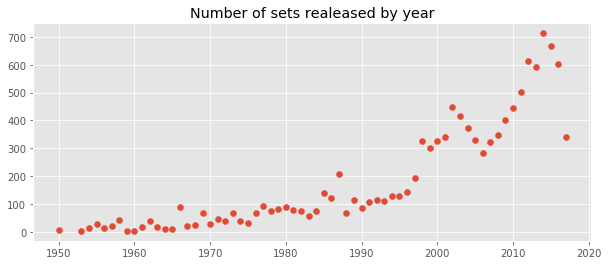

In [16]:
sd = sets.groupby('year')['year'].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(sd.index,sd.values)
ax.set_title('Number of sets realeased by year');

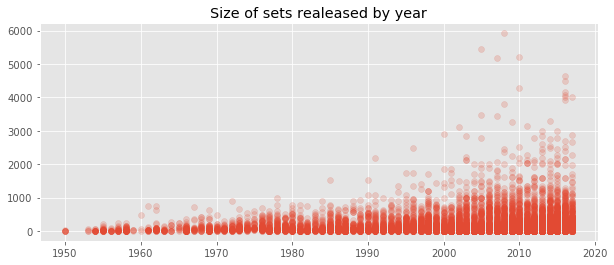

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(sets['year'],sets['num_parts'],alpha=.2)
ax.set_title('Size of sets realeased by year');

### Inventory_parts: Indexed by the ID from Inventory
### There is a line for each part in each kit, over 1/2 million rows

In [18]:
inventory_parts[:10]

,inventory_id,part_num,color_id,quantity,is_spare
0,1,48379c01,72,1,f
1,1,48395,7,1,f
2,1,mcsport6,25,1,f
3,1,paddle,0,1,f
4,3,11816pr0005,78,1,f
5,3,2343,47,1,f
6,3,3003,29,1,f
7,3,30176,2,1,f
8,3,3020,15,1,f
9,3,3022,15,2,f


In [19]:
#sets[sets['set_num'].str.contains('75912')]
sets[sets['set_num'].str.contains('1076-3')]

,set_num,name,year,theme_id,num_parts
457,1076-3,Advent Calendar 1999 (Day 2) Snowman,1999,217,11


In [20]:
#inventories[inventories['set_num'].str.contains('75912')]
inventories[inventories['set_num']=='1076-3']

,id,version,set_num
13,29,1,1076-3


In [21]:
inventory_sets[inventory_sets['set_num'].str.contains('75912')]

,inventory_id,set_num,quantity
1,35,75912-1,1


In [22]:
print "Individual parts =", len(inventory_parts[inventory_parts['inventory_id']==703])
print "total parts =", sum(inventory_parts[inventory_parts['inventory_id']==703]['quantity'])

Individual parts = 225
total parts = 599


In [23]:
#inventory_parts[inventory_parts['inventory_id']==703]
inventory_parts[inventory_parts['inventory_id']==29]

,inventory_id,part_num,color_id,quantity,is_spare
384,29,3003,0,1,f
385,29,3004,15,1,f
386,29,3005pe1,15,2,f
387,29,3020,0,1,f
388,29,3022,0,1,f
389,29,3039,15,2,f
390,29,3660,15,2,f
391,29,3731,4,1,f


### Trying to automate a few things
Given a list of set numbers from the set file, count unique parts and total parts

In [24]:
short_set_list = sets[2000:2004]
short_set_list

,set_num,name,year,theme_id,num_parts
2000,30073-1,Buzz's Mini Ship,2010,275,20
2001,30080-1,Ninja Glider,2011,435,26
2002,30081-1,Skeleton Chopper,2011,435,41
2003,30082-1,Enemy Training,2011,435,32


In [25]:
for kit in short_set_list['set_num']:
    print_kit_summary(kit)

Kit number= 30073-1
ID number = 4676
part count= 20
Individual parts = 16
total parts = 22

Kit number= 30080-1
ID number = 4682
part count= 26
Individual parts = 14
total parts = 26

Kit number= 30081-1
ID number = 15828
part count= 41
Individual parts = 22
total parts = 42

Kit number= 30082-1
ID number = 10228
part count= 32
Individual parts = 24
total parts = 34



### Automate something else: from a kit number, build a list or dictionary of part numbers

In [26]:
sets[sets['set_num'].str.contains('75912')]

,set_num,name,year,theme_id,num_parts
8400,75912-1,Porsche 911 GT Finish Line,2015,601,561


In [27]:
short_set_list = sets[8355:8356]

In [31]:
for kit in short_set_list['set_num']:
    print_kit_summary(kit)
    part_list = inventory_parts[inventory_parts['inventory_id']==set_id_from_kit_name(kit)]

Kit number= 7578-1
ID number = 2469
part count= 158
Individual parts = 71
total parts = 163



In [32]:
part_list

,inventory_id,part_num,color_id,quantity,is_spare
83175,2469,14210,2,1,f
83176,2469,22670,63,2,f
83177,2469,2343,47,1,f
83178,2469,2417,10,2,f
83179,2469,2555,15,7,f
83180,2469,3004,15,5,f
83181,2469,30044,15,4,f
83182,2469,30046,52,4,f
83183,2469,3005,15,3,f
83184,2469,3005,114,6,f


In [33]:
print "Part number (Design ID) = 3003 is the basic 2x2 square brick"
print len(inventory_parts[inventory_parts['part_num']=='3003'])

Part number (Design ID) = 3003 is the basic 2x2 square brick
6366


In [34]:
print len(parts[parts['part_num'].str.contains('3001')])
parts[parts['part_num'].str.contains('3001')]

66


,part_num,name,part_cat_id
4808,3001,Brick 2 x 4,11
4809,30013,LEGO Dog with Hole Dia. 1.5 (30013),28
4810,30014,Arm Holder Brick 1 x 2 with 2 Horizontal Fingers,18
4811,30016,"Belville Wall, Lattice 6 x 6 x 12 Corner",42
4812,30018,Bathtub 6 x 12,7
4813,3001a,Brick 2 x 4 without Cross Supports,11
4814,3001apb01,Brick 2 x 4 with 4 Plane Windows in Thin Red ...,2
4815,3001apb02,Brick 2 x 4 with Red 'SHELL' Print,2
4816,3001apb03,Brick 2 x 4 with Plane Windows 8 in Thin Blue ...,2
4817,3001apb04,Brick 2 x 4 with Plane Windows 8 in Thin Red S...,2


Now, what about getting some pictures for comparison?
Photo booth pics, if not moved, are in  
~/Pictures/Photo Booth Library/Pictures

In [35]:
pathData = '~/Pictures/Photo Booth Library/Pictures/'
pathData = '~/Pictures/'
!ls {pathData}

Photo Booth Library              Photo on 7-30-17 at 12.59 PM.jpg
Photo on 7-30-17 at 1.00 PM.jpg  Photos Library.photoslibrary


## Connect the lego piece ID (part + color) to the lego part ID (part shape only)

rebrickable part IDs correspond to lego "design ID" numbers

### NOTE: the dictionary below is keyed by the design ID number, so the values are the last in the file.  If we want unique mapping, the Brick has to be the key, and the Part the value belwo

In [36]:
bric_dict={}
info_dir = '~/Documents/Lego creations/Models/'
name_list = ['rectangular_bricks_01.csv','rounded_bricks_02.csv',
             'small_rectangles_03.csv','technic_04.csv','roof_tiles_05',
             'roof_and_vehicles_06','bows_and_curves_07','flats_08',
             'more_flats_09','clips_and_hinges_10']
for name in name_list:
    fname = info_dir + name
    model=pd.read_csv(fname)
    model=model[model['Brick']!='Total:']
    for Brick,Part in zip(model['Brick'],model['Part']):
        bric_dict[int(Part)]=int(Brick)

### What lego shapes are in the most kits?


In [37]:
part_kit_count = {}
for key in inventory_parts['part_num']:
    part_kit_count[key] = part_kit_count.get(key,0)+1
sorted_part_kit_count = sorted(part_kit_count.iteritems(),key=operator.itemgetter(1), reverse=True)

In [38]:
for row in sorted_part_kit_count[:10]:
    print "Part shape = {:>6}, # of kits = {:<6,}, and Lego ID = {}".format(
            row[0],row[1],bric_dict.get(int(row[0]),0))

Part shape =   6141, # of kits = 16,691, and Lego ID = 0
Part shape =   3023, # of kits = 10,467, and Lego ID = 0
Part shape =   3004, # of kits = 8,680 , and Lego ID = 300424
Part shape =   3020, # of kits = 7,632 , and Lego ID = 0
Part shape =   3022, # of kits = 7,120 , and Lego ID = 0
Part shape =  54200, # of kits = 7,110 , and Lego ID = 0
Part shape =   3710, # of kits = 6,949 , and Lego ID = 0
Part shape =   3024, # of kits = 6,375 , and Lego ID = 0
Part shape =   3003, # of kits = 6,366 , and Lego ID = 300323
Part shape =   3005, # of kits = 5,684 , and Lego ID = 300523


### What would be the most popular legos if you got one of every kit?

In [39]:
part_pop_count ={}
for key,num in zip(inventory_parts['part_num'],inventory_parts['quantity']):
    part_pop_count[key] = part_pop_count.get(key,0)+num
sorted_part_pop_count = sorted(part_pop_count.iteritems(),key=operator.itemgetter(1), reverse=True)

In [40]:
for row in sorted_part_pop_count[:10]:
    print "Part shape = {:>6}, piece counts = {:<6,}, and Lego ID = {}".format(
            row[0],row[1],bric_dict.get(int(row[0]),0))

Part shape =   3004, piece counts = 69,462, and Lego ID = 300424
Part shape =   3023, piece counts = 59,221, and Lego ID = 0
Part shape =   6141, piece counts = 53,995, and Lego ID = 0
Part shape =   3003, piece counts = 48,805, and Lego ID = 300323
Part shape =   3005, piece counts = 47,088, and Lego ID = 300523
Part shape =   3024, piece counts = 42,261, and Lego ID = 0
Part shape =   2780, piece counts = 40,884, and Lego ID = 0
Part shape =   3010, piece counts = 29,914, and Lego ID = 4209869
Part shape =   3001, piece counts = 29,166, and Lego ID = 300123
Part shape =   3710, piece counts = 28,958, and Lego ID = 0


## Start selecting a subset of the kits for tf-idf exploration
Looking at 5 of the biggest kits and 10 of the smallest kits, based on "sets" df

In [41]:
sets_by_size = sets.sort_values(by='num_parts',axis=0)
tiny_sets = sets[sets['num_parts']==10]
big_sets = sets[sets['num_parts']>3000]
big_sets

,set_num,name,year,theme_id,num_parts
57,10030-1,Imperial Star Destroyer - UCS,2002,174,3115
126,10143-1,Death Star II,2005,174,3460
161,10179-1,Millennium Falcon - UCS,2007,174,5195
162,10181-1,Eiffel Tower 1:300 Scale,2007,276,3428
169,10188-1,Death Star,2008,174,3807
170,10189-1,Taj Mahal,2008,276,5922
177,10196-1,Grand Carousel,2009,276,3260
195,10214-1,Tower Bridge,2010,276,4295
202,10221-1,Super Star Destroyer,2011,174,3151
234,10253-1,Big Ben,2016,43,4166


In [42]:
tiny_advent_1999 = sets[(sets['year']==1999) & (sets['name'].str.contains('Advent'))]
tiny_advent_1999

,set_num,name,year,theme_id,num_parts
439,1076-1,Advent Calendar 1999,1999,207,228
440,1076-10,Advent Calendar 1999 (Day 9) Fire Engine,1999,217,10
441,1076-11,Advent Calendar 1999 (Day 10) Santa Minifig,1999,217,5
442,1076-12,Advent Calendar 1999 (Day 11) Dog,1999,217,8
443,1076-13,Advent Calendar 1999 (Day 12) Hippo,1999,217,9
444,1076-14,Advent Calendar 1999 (Day 13) Hovercraft,1999,217,10
445,1076-15,Advent Calendar 1999 (Day 14) Penguin,1999,217,8
446,1076-16,Advent Calendar 1999 (Day 15) Elf,1999,217,12
447,1076-17,Advent Calendar 1999 (Day 16) Seaplane,1999,217,10
448,1076-18,Advent Calendar 1999 (Day 17) Gentleman,1999,217,10


In [43]:
small_sets = sets[(sets['num_parts']>10) & (sets['num_parts']<50)]
small_sets.shape

(3150, 5)

## tf-idf
see http://localhost:8888/notebooks/week6/nlp/jf_omhover/nlp-lecture.ipynb  
starting at "Text Featurization part 2 : Indexing Bag-of-Words into a vector table" 

### For the first draft, let's do a document dictionary of all 3150 "small sets" which have between 10 and 50 parts
for each "document" (set) we need a list of the tokens (part names) in the set  
then the bows="Bag of words" will be a list of these lists  

In [44]:
set_list = list(small_sets['set_num'])
set_list = ['1076-2','1076-3','1076-7']
#print set_list[:4]

# bows -- list of lists of lego parts in each kit
bows=[]

# term_occ -- list of dictionaries of all words and their frequencies
term_occ = []
term_freq = []

# occ -- dictionary of all words and their frequencies in all kits together
occ = {}

In [45]:
for lego_set in set_list:
    this_set_occ,this_set_term_freq,this_set_parts,inventory_id = lists_from_inv_id(
        lego_set,occ)
    term_occ.append(this_set_occ)
    term_freq.append(this_set_term_freq)
    bows.append(list(this_set_parts['part_num']))
    
    print "lego set = {}, inventory id = {}".format(lego_set,inventory_id)

lego set = 1076-2, inventory id = 7015
lego set = 1076-3, inventory id = 29
lego set = 1076-7, inventory id = 5669


In [46]:
print "bag of words: list of lists of lego parts in each kit"
print bows
print
print "term_occ -- list of dictionaries of all words and their frequencies"
print term_occ
print
print "term_freq -- list of each term_occ as percent of set"
print term_freq
print
print "occ -- dictionary of all words and their frequencies in all kits together"
print occ

bag of words: list of lists of lego parts in each kit
[['2496', '2655', '3020', '3020', '3021', '3021', '3039', '3747b', '6141', '6141'], ['3003', '3004', '3005pe1', '3020', '3022', '3039', '3660', '3731'], ['3001', '3003', '3004', '3005pe1', '3021', '3023', '3039', '3710']]

term_occ -- list of dictionaries of all words and their frequencies
[{'3747b': 1, '3039': 1, '3021': 3, '3020': 2, '6141': 2, '2655': 1, '2496': 1}, {'3039': 2, '3022': 1, '3020': 1, '3004': 1, '3005pe1': 2, '3003': 1, '3731': 1, '3660': 2}, {'3039': 2, '3023': 2, '3021': 1, '3004': 2, '3001': 1, '3005pe1': 2, '3003': 1, '3710': 1}]

term_freq -- list of each term_occ as percent of set
[{'3747b': 0.090909090909090912, '3039': 0.090909090909090912, '3021': 0.27272727272727271, '3020': 0.18181818181818182, '6141': 0.18181818181818182, '2655': 0.090909090909090912, '2496': 0.090909090909090912}, {'3039': 0.18181818181818182, '3022': 0.090909090909090912, '3020': 0.090909090909090912, '3004': 0.090909090909090912, '30

In [49]:
inventory_parts[inventory_parts['inventory_id']==7015]

,inventory_id,part_num,color_id,quantity,is_spare
236295,7015,2496,0,1,f
236296,7015,2655,14,1,f
236297,7015,3020,1,1,f
236298,7015,3020,14,1,f
236299,7015,3021,14,1,f
236300,7015,3021,1,2,f
236301,7015,3039,47,1,f
236302,7015,3747b,4,1,f
236303,7015,6141,36,1,f
236304,7015,6141,34,1,f


Copy directly from section 1.1 to get tf

In [50]:
# document occurence = number of documents having this word
# term frequency = occurences over length of bag

doc_occ = Counter( [word for bow in bows for word in set(bow)] )

# document frequency = occurences over length of corpus
doc_freq = {k: (v / float(len(bows)))
            for k, v in doc_occ.items()}

# displaying vocabulary
print("\n--- full vocabulary: {}".format(doc_occ))
print("\n--- doc freq: {}".format(doc_freq))


--- full vocabulary: Counter({'3039': 3, '3020': 2, '3004': 2, '3021': 2, '3003': 2, '3005pe1': 2, '3747b': 1, '3023': 1, '3022': 1, '2655': 1, '6141': 1, '3660': 1, '3001': 1, '2496': 1, '3710': 1, '3731': 1})

--- doc freq: {'3747b': 0.3333333333333333, '3005pe1': 0.6666666666666666, '3039': 1.0, '3023': 0.3333333333333333, '3022': 0.3333333333333333, '2655': 0.3333333333333333, '3020': 0.6666666666666666, '3004': 0.6666666666666666, '6141': 0.3333333333333333, '3001': 0.3333333333333333, '3021': 0.6666666666666666, '3003': 0.6666666666666666, '2496': 0.3333333333333333, '3710': 0.3333333333333333, '3731': 0.3333333333333333, '3660': 0.3333333333333333}


In [51]:
# The vocabulary for indexing, section 1.3 in nlp lecture

# the minimum document frequency (in proportion of the length of the corpus)
min_df = 0.3

# filtering items to obtain the vocabulary
vocabulary = [ k for k,v in doc_freq.items() if v >= min_df ]

# print vocabulary
print ("-- vocabulary (len={}): {}".format(len(vocabulary),vocabulary))

-- vocabulary (len=16): ['3747b', '3005pe1', '3039', '3023', '3022', '2655', '3020', '3004', '6141', '3001', '3021', '3003', '2496', '3710', '3731', '3660']


In [52]:
# section 1.4 -- tf-idf

# create a dense matrix of vectors for each document
# each vector has the length of the vocabulary
vectors = np.zeros((len(bows),len(vocabulary)))

# fill these vectors with tf-idf values
for i in range(len(bows)):
    for j in range(len(vocabulary)):
        term     = vocabulary[j]
        term_tf  = term_freq[i].get(term, 0.0)   # 0.0 if term not found in doc
        term_idf = np.log(1 + 1 / doc_freq[term]) # smooth formula
        vectors[i,j] = term_tf * term_idf

# displaying results
for i in range(len(bows)):
    print("\n--- bow: {}".format(bows[i]))
    print("--- tfidf vector: {}".format( vectors[i] ) )
    print("--- tfidf sorted: {}".format( 
            sorted( zip(vocabulary,vectors[i]), key=lambda x:-x[1] )
         ))


--- bow: ['2496', '2655', '3020', '3020', '3021', '3021', '3039', '3747b', '6141', '6141']
--- tfidf vector: [ 0.12602676  0.          0.06301338  0.          0.          0.12602676
  0.16659831  0.          0.25205352  0.          0.24989747  0.
  0.12602676  0.          0.          0.        ]
--- tfidf sorted: [('6141', 0.25205352020361649), ('3021', 0.249897472329315), ('3020', 0.16659831488621002), ('3747b', 0.12602676010180824), ('2655', 0.12602676010180824), ('2496', 0.12602676010180824), ('3039', 0.063013380050904122), ('3005pe1', 0.0), ('3023', 0.0), ('3022', 0.0), ('3004', 0.0), ('3001', 0.0), ('3003', 0.0), ('3710', 0.0), ('3731', 0.0), ('3660', 0.0)]

--- bow: ['3003', '3004', '3005pe1', '3020', '3022', '3039', '3660', '3731']
--- tfidf vector: [ 0.          0.16659831  0.12602676  0.          0.12602676  0.
  0.08329916  0.08329916  0.          0.          0.          0.08329916
  0.          0.          0.12602676  0.25205352]
--- tfidf sorted: [('3660', 0.25205352020361

#### Then take a mixed list of 10 sets, call them one batch, and see what appears to be similar by tf-idf.

In [55]:
test_set_list = ['1076-12','1076-13','1076-14']


#### Next, from the tf-idf list, show how complete those top matches can be from the batch.
Calculate the cosine similarity between the new bag and each set in the original bow.  
List the top 5 matches (highest similarity).  
List the percent complete we can be with each set, allowing duplication.  
List the percent complete we can get for an ensemble of the top 5 sets.

#### Afterwards, repeat with 90% complete sets in the batch